Author: Ahmed Sobhi

Creation_date: 16th June 2023

Objective: Data Modeling.

## Importing Required Libararies and packages

In [40]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
# Used for visulization
import matplotlib.pyplot as plt
import seaborn as sns

# For iteration visulization purpose
from tqdm import tqdm

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# To save the model locally
import joblib

## Loading Dataset

In [42]:
# Load orders dataset
df = (
    pd.read_csv("../data/intermid/DS-task-data-processed.csv")
    .assign(
        priced_at=lambda x: pd.to_datetime(x.priced_at)
    )
)

# Load extra_features dataset
df_extrafeatures = pd.read_csv('../data/intermid/features_ohe.csv')

df.head(1)

,id,make,model,model_year,kilometers,transmission_type,price,priced_at,mileage_category,extra_features_count,model_age,price_moving_avg,competitor_price_diff,popularity,price_change_pct,dt_year,dt_month,dt_day,dt_quarter
0,17786,Nissan,Juke,2008,200000.0,Automatic,115000,2022-02-11,200k+,26,14,115000,-500.0,0.31,0.008696,2022,2,11,1


In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,18560.0,1.002587e+04,5797.828096,0.000000,5017.750000,10021.500000,15013.250000,2.009700e+04
model_year,18560.0,2.016373e+03,4.330355,1999.000000,2014.000000,2017.000000,2020.000000,2.023000e+03
kilometers,18560.0,9.431014e+04,59968.258248,0.000000,41675.000000,90000.000000,139999.000000,2.850000e+05
price,18560.0,2.748812e+05,128976.204012,1000.000000,181000.000000,248000.000000,338000.000000,1.384000e+06
extra_features_count,18560.0,1.245323e+01,7.795204,1.000000,6.000000,9.000000,18.000000,3.900000e+01
model_age,18560.0,5.825431e+00,4.277615,-1.000000,3.000000,5.000000,8.000000,2.400000e+01
price_moving_avg,18560.0,2.745299e+05,124790.002278,67800.000000,183000.000000,247400.000000,335600.000000,1.240800e+06
competitor_price_diff,18560.0,1.204296e-12,67340.776500,-425791.044776,-42011.827957,-9312.807882,39232.583065,7.286872e+05
popularity,18560.0,3.698048e+00,1.949262,0.000000,1.100000,5.000000,5.000000,5.000000e+00
price_change_pct,18560.0,7.450694e-02,5.555910,-0.998347,-0.084489,0.000000,0.096447,5.500000e+02


In [44]:
# Merge with extra_features 
df_set = df.merge(
    df_extrafeatures.drop(['extra_features_lst', 'extra_features_count'], axis=1),
    how='left',
    on='id'
)

# Remove unnessary columns
df_set = df_set.drop(['id', 'make', 'kilometers'], axis=1)

df_set.head()

,model,model_year,transmission_type,price,priced_at,mileage_category,extra_features_count,model_age,price_moving_avg,competitor_price_diff,...,sensors,sideairbag,startengine,steptronic,sunroof,tintedglass,touchactivateddoorlock,touchscreen,tractioncontrol,usb
0,Juke,2008,Automatic,115000,2022-02-11,200k+,26,14,115000,-500.0,...,1,0,0,0,1,0,0,1,0,1
1,Juke,2008,Automatic,116000,2022-04-21,200k+,26,14,115000,500.0,...,1,0,0,0,1,0,0,1,0,1
2,Juke,2009,Automatic,239000,2022-06-01,0-50k,26,13,115500,0.0,...,1,0,0,0,1,0,0,1,0,1
3,Juke,2010,Automatic,195000,2022-02-07,100k-150k,26,12,156666,0.0,...,1,0,0,0,1,0,0,1,0,1
4,Juke,2011,Automatic,248000,2022-06-29,0-50k,7,11,166250,0.0,...,0,0,0,0,0,0,0,0,0,0


## Train validation split

In [45]:
target_col = 'price'

# Select features only
df_features = df_set.drop(target_col, axis=1)

df_y = df_set[target_col]

x_train, x_val, y_train, y_val = train_test_split(
    df_features,
    df_y,
    test_size=0.2,
    random_state=42,
    stratify=df_features['model']
)

## Pipeline Steps

In [50]:
# Extract numerical|Categorical features
df_uniques = (
    pd.DataFrame(
        [[i, len(df_extrafeatures[i].unique())] for i in df_extrafeatures.columns],
          columns=['Variable', 'Unique Values']).set_index('Variable')
)

ohe_ecnoded_features = list(df_uniques[df_uniques['Unique Values'] == 2].index)

numeric_features = list(set(df_features.select_dtypes('number').columns.tolist()) - set(ohe_ecnoded_features))

categorical_features = df_features.select_dtypes('object').columns.tolist()

df_features[numeric_features].replace([np.inf, -np.inf], np.nan, inplace=True)

imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

numeric_transformer = Pipeline(
    [
        ('impute', imputer_numeric),
        ('scaler', StandardScaler())
    ]
)

ohe_encoded_transformer = Pipeline([
    ('impute', imputer_numeric)
])
categorical_transformer = Pipeline(
    [
        ('impute', imputer_categorical),
        ('ohc', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('numericals', numeric_transformer, numeric_features),
        ('ohe_encdode', ohe_encoded_transformer, ohe_ecnoded_features),
        ('Categorical', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    n_jobs=-1
)

In [52]:
# # Testing
# preprocessor.fit(df_features)

# preprocessor.transform(df_features)

## Model Pipeline

In [53]:
initial_lr = 0.05

model = XGBRegressor(objective='reg:squarederror',
                     colsample_bytree=0.5,
                     learning_rate=initial_lr,
                     max_depth=6,
                     min_child_weight=1,
                     n_estimators=1000,
                     subsample=0.99,
                     verbosity=1,
                     n_jobs=-1)

model_pipeline = Pipeline(
    steps=[
        ('col_trans', preprocessor),
        ('model', model)
    ]
)

In [54]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numericals',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dt_day', 'price_change_pct',
                                                   'popularity',
                                                   'price_moving_avg',
                                                   'model_age', 'dt_year',
                                                   'dt_quarter', 'model_year',
                                                   'extra_features_count',
                                                   'competitor_price_diff',
                                                   'dt_month']),
                                                 ('ohe_encdode',
                                                  Pipeline...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=1000, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

## Saving the model

In [55]:
# Save the model
if not os.path.exists('../src/model/'):
        os.makedirs('../src/model/')

joblib.dump(model_pipeline, f'../src/model/xgboost_model.pkl')

['../src/model/xgboost_model.pkl']

## Loading the model

In [56]:
# Load the model
model_load = joblib.load(f'../src/model/xgboost_model.pkl')

## Prediction step

In [57]:
pred_train = model_load.predict(x_train).round()

pred_val = model_load.predict(x_val).round()

## Calculating RMSE

In [58]:
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

rmse_val = mean_squared_error(y_val, pred_val, squared=False)

print(f"RMSE:\n\tTrain Set = {rmse_train}\n\tVal Set = {rmse_val}")

RMSE:
	Train Set = 2213.320745939758
	Val Set = 8239.4070144412


### Note: 
- As we are dealing with Regression problem, we don't have such Accuracy metric, So Depending on Bussiness, An accuracy metric could be defined as measurable & understandable method.

## Feature Importance

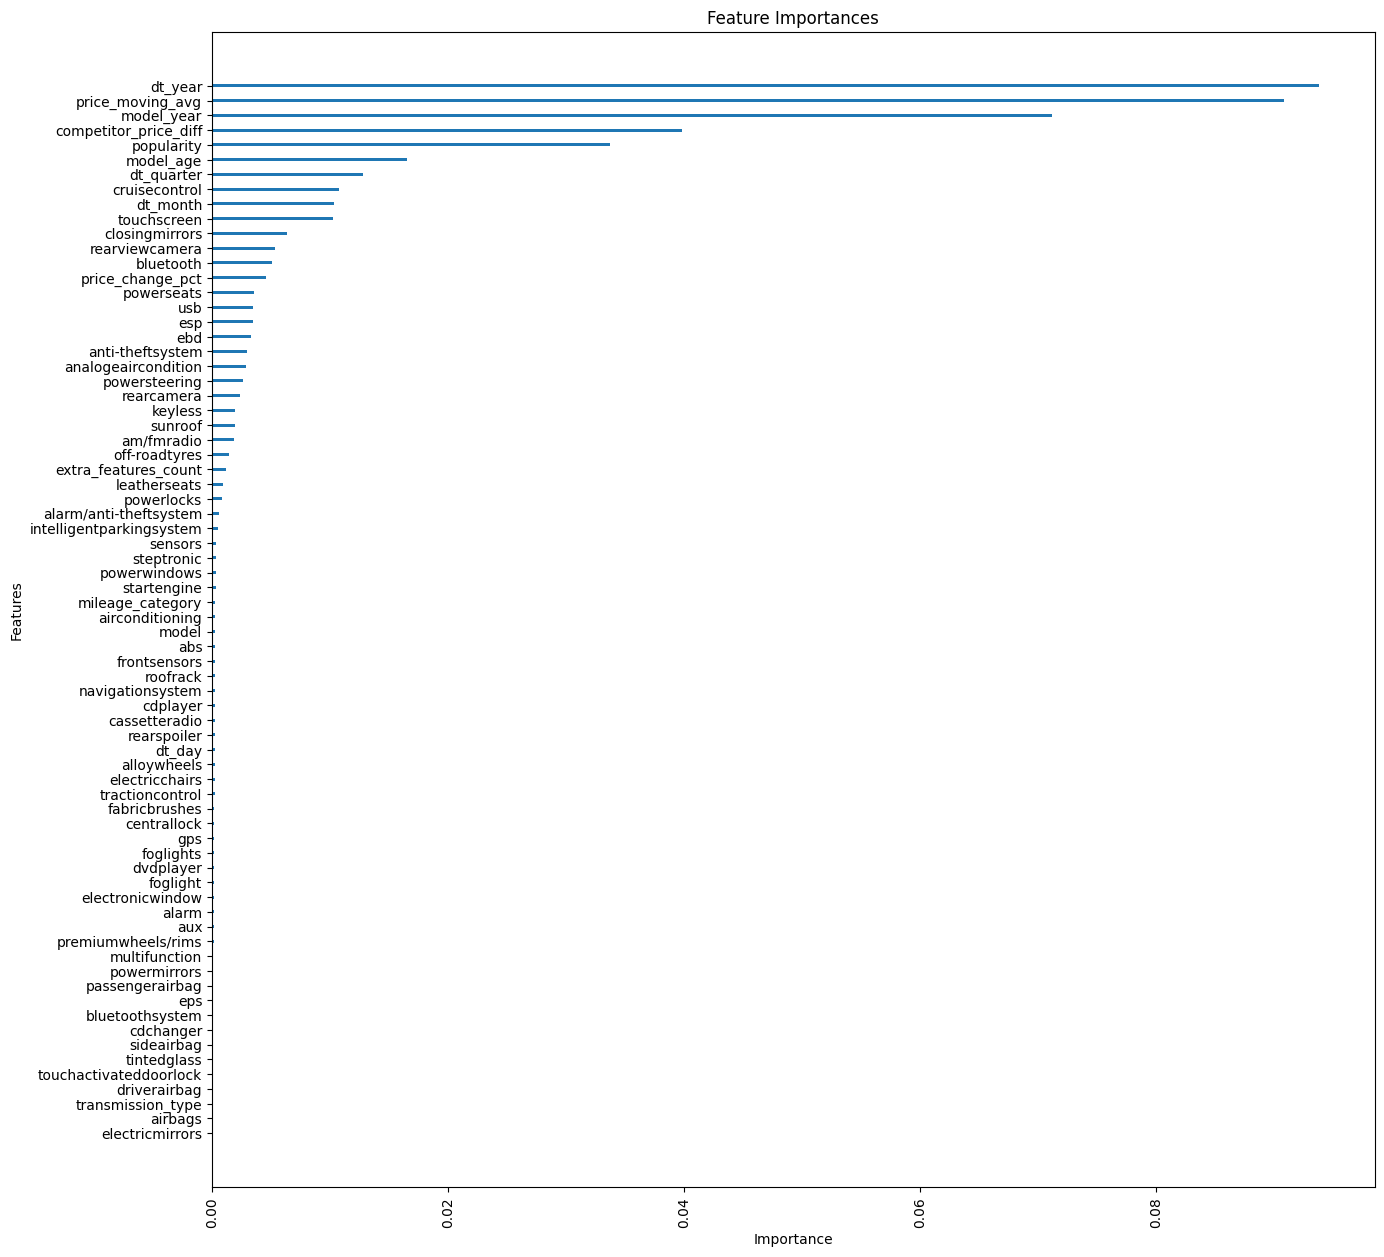

In [63]:
# Get features importances
features_importances = model_load.named_steps['model'].feature_importances_

# Get the ColumnTransformer step
column_transformer = model_load.named_steps['col_trans']

# Get the numerical feature names
numerical_features = column_transformer.transformers_[0][2]
ohe_ecnoded_features = column_transformer.transformers[1][2]

# Get the one-hot encoded feature names
one_hot_encoder = column_transformer.named_transformers_['Categorical'].named_steps['ohc']
# categorical_features = one_hot_encoder.get_feature_names_out(column_transformer.transformers_[1][2])

# Combine feature names and importances
feature_names = np.concatenate((numerical_features, ohe_ecnoded_features, categorical_features))
importances = np.concatenate((features_importances[:len(numerical_features)+len(ohe_ecnoded_features)], features_importances[len(numerical_features):]))

importances, feature_names = zip(*sorted(zip(importances, feature_names)))

# Plot the feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_names, importances, height=0.2)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
# plt.savefig('../report/plots/feature_importance_v0.png', bbox_inches='tight')
plt.show()

In [64]:
df_features_import = pd.DataFrame({'feature':feature_names, 'importance':importances})
df_features_import = df_features_import.sort_values('importance', ascending=False)
df_features_import

,feature,importance
71,dt_year,0.093816
70,price_moving_avg,0.090875
69,model_year,0.071179
68,competitor_price_diff,0.039788
67,popularity,0.033740
...,...,...
4,touchactivateddoorlock,0.000097
3,driverairbag,0.000097
2,transmission_type,0.000086
1,airbags,0.000086


In [65]:
df_features_import.to_csv(f'../data/output/feature_importance.csv', index=False)